The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Generating 4004001 rays...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [180..689].


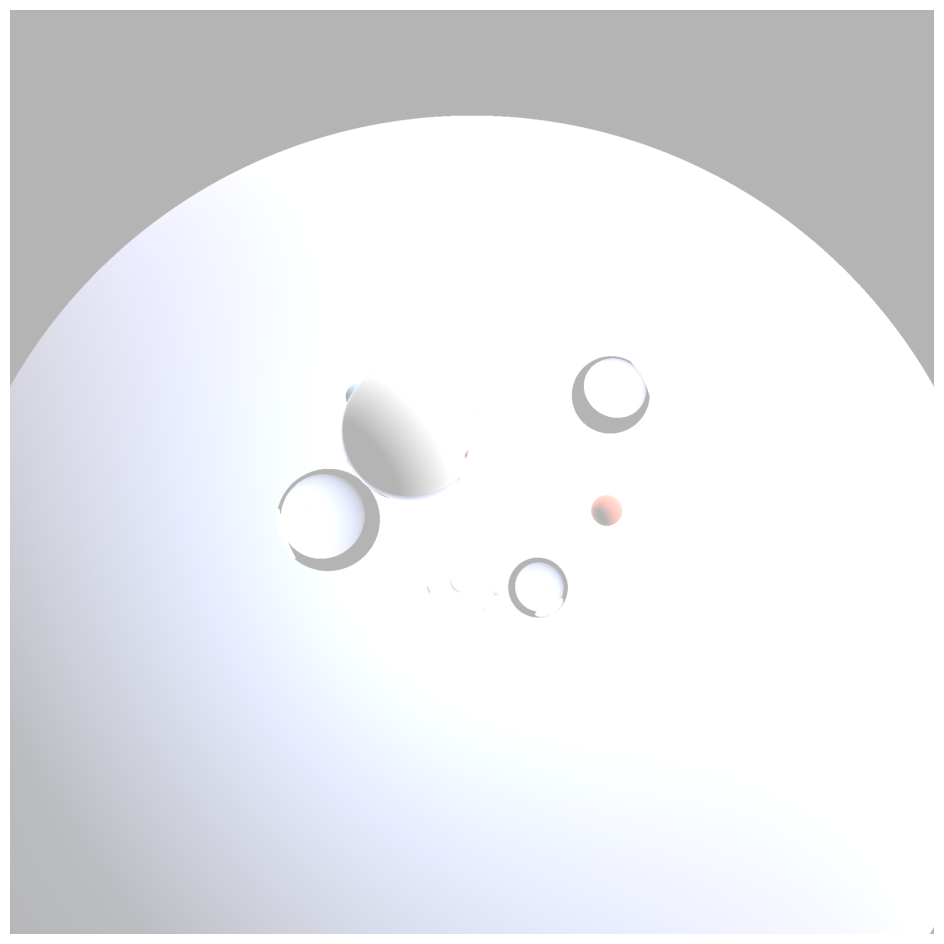

In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from vector import Vector
from object import Sphere
from ray import Ray, Intersection
from material import Material
from colour import Colour
from light import GlobalLight, PointLight


# === MATERIALS ===
base_material = Material()
emitive_material = Material(emitive=True)
reflective_material = Material(reflective=True)
glass = Material(reflective=False, transparent=True, refractive_index=1.52)

# === SPHERES (OBJECTS IN SCENE) ===

# A glowing vertical “rift” (long, thin glowing sphere)
rift = Sphere(
    id=0,
    centre=Vector(0, 0, -1.5),
    radius=0.55,
    material=emitive_material,
    colour=Colour(180, 220, 255)
)

# Huge reflective planet in the distance
planet = Sphere(
    id=1,
    centre=Vector(0, -3, -15),
    radius=10,
    material=reflective_material,
    colour=Colour(200, 200, 255)
)

# Floating crystal spheres orbiting the rift
crystal1 = Sphere(
    id=2,
    centre=Vector(0.9, 0.5, -1),
    radius=0.25,
    material=glass,
    colour=Colour(120, 180, 255)
)

crystal2 = Sphere(
    id=3,
    centre=Vector(-0.9, -0.3, -0.8),
    radius=0.32,
    material=glass,
    colour=Colour(255, 160, 240)
)

crystal3 = Sphere(
    id=4,
    centre=Vector(0.4, -0.7, -0.6),
    radius=0.18,
    material=glass,
    colour=Colour(180, 255, 200)
)

# A reflective “sentinel” sphere in the foreground
sentinel = Sphere(
    id=5,
    centre=Vector(-0.3, 0.2, 0.4),
    radius=0.35,
    material=reflective_material,
    colour=Colour(255, 255, 255)
)

# Tiny colored accent spheres drifting around
tiny1 = Sphere(
    id=6,
    centre=Vector(0.7, -0.2, 0.2),
    radius=0.08,
    material=base_material,
    colour=Colour(255, 80, 60)
)

tiny2 = Sphere(
    id=7,
    centre=Vector(-0.6, 0.4, 0.1),
    radius=0.07,
    material=base_material,
    colour=Colour(100, 200, 255)
)

spheres = [rift, planet, crystal1, crystal2, crystal3, sentinel, tiny1, tiny2]

# === LIGHT SOURCES ===

global_light_sources = []
global_light_sources.append(
    GlobalLight(
        vector=Vector(2, 1.5, -1),
        colour=Colour(255, 255, 255),
        strength=1,
        max_angle=np.radians(140),
        func=0
    )
)

# The rift emits light like a portal
point_light_sources = []
rift_light = PointLight(
    id=rift.id,
    position=rift.centre,
    colour=rift.colour,
    strength=1.4,
    max_angle=np.radians(120),
    func=0
)
point_light_sources.append(rift_light)

# Camera
ray_origin = Vector(0, 0, 5)
rays = []

"""
Generate a pixel grid of rays.
"""
RAY_COUNT = 100  
RAY_STEP = 0.005   

multiple = 10    
RAY_COUNT *= multiple
RAY_STEP /= multiple

X_RAYS = [r*RAY_STEP for r in range(-RAY_COUNT, 0, 1)] + [r*RAY_STEP for r in range(0, RAY_COUNT + 1)]
Y_RAYS = [r*RAY_STEP for r in range(RAY_COUNT, 0, -1)] + [-r*RAY_STEP for r in range(0, RAY_COUNT + 1)]
Z = -1

MAX_BOUNCES = 10

TOTAL_RAYS = len(X_RAYS) * len(Y_RAYS)

print(f"Generating {TOTAL_RAYS} rays...")
for Y in Y_RAYS:
    for X in X_RAYS:
        ray = Ray(
            origin=ray_origin,
            D=Vector(x=X, y=Y, z=-1)
        )
        rays.append(ray)

max_angle = np.radians(90)
background_colour = Colour(180, 180, 180)
black_colour = Colour(0, 0, 1)

pixels = []

progress_milestones = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
"""
For each ray, find its nearest intersection and set the pixel color accordingly
"""
for i, ray in enumerate(rays):

    progress = (i+1) / len(rays) * 100
    if progress > progress_milestones[0]:
        progress_milestones.pop(0)
        print(f"Casting Rays: {progress:.0f}%", end="\r")

    
    ray_terminal = ray.nearestSphereIntersect(spheres, max_bounces=MAX_BOUNCES)

    if ray_terminal == None:
        pixels.append(background_colour.getList())

    else:
        pixels.append(ray_terminal.terminalRGB(
            spheres=spheres,
            background_colour=background_colour,
            global_light_sources=global_light_sources,
            point_light_sources=point_light_sources
        ).getList())

X_SIZE = len(X_RAYS)
Y_SIZE = len(Y_RAYS)

pixels = np.array(pixels).reshape((X_SIZE, Y_SIZE, 3))

plt.figure(figsize=(12, 12))  
plt.imshow(pixels)
plt.axis('off')
plt.savefig('fun_6.png', bbox_inches='tight')
plt.show()